In [1]:
import torch
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
import torch.nn.functional as F
from pipeline_flux_non_rigid import FluxPipeline
from transformer_flux_non_rigid import FluxTransformer2DModel
import string
from diffusers.utils.torch_utils import randn_tensor
from non_rigid_attn_utils import register_non_rigid_attention_control
from PIL import Image
from diffusers.models.attention_processor import FluxAttnProcessor2_0
from utils import resize_and_concat_images

In [2]:
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
flux_transfomer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-dev", subfolder="transformer", torch_dtype=torch.bfloat16)
pipe.transformer = flux_transfomer

device = "cuda:0"
pipe = pipe.to(device)

height = 1024
width = 1024

processor_args = {
    "start_step": 0,
    "start_layer": 0,
    "layer_idx":[0,7,8,9,10,18,25,28,37,42,45,50,56],
    "step_idx": list(range(0,50)),
    "total_layers": 57,
    "total_steps": 50,
}

def register_ori_attention(model):
    attn_procs = FluxAttnProcessor2_0()
    model.transformer.set_attn_processor(attn_procs)
    print(f"Model {model.transformer.__class__.__name__} is registered attention processor: FluxAttnProcessor2_0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
prompt = ['a bird perched on a branch', 'a bird flying from the branch'] #[src_prompt, tar_prompt]
seed = 2
generator = torch.Generator("cuda").manual_seed(seed)
shape = (1, 16, height//8, width//8)
latents = randn_tensor(shape, generator=generator, device=pipe._execution_device, dtype=torch.bfloat16).expand(len(prompt), -1, -1, -1)
latents = pipe._pack_latents(latents, len(prompt), 16, height//8, width//8)

Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0


  0%|          | 0/50 [00:00<?, ?it/s]

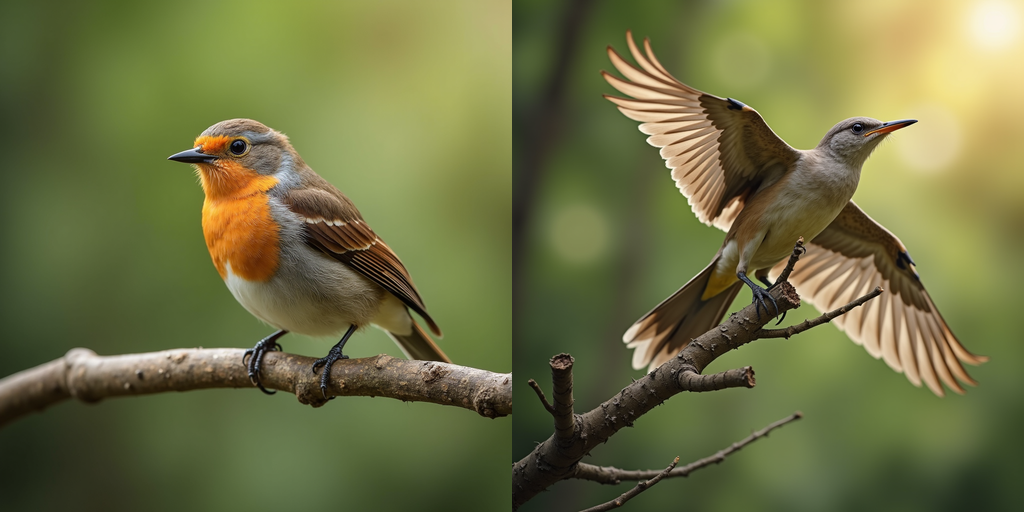

In [4]:
register_ori_attention(pipe)
image_ori_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
).images
display(resize_and_concat_images(image_ori_list))

Non-Rigid Editing at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Non-Rigid Editing at U-Net layers:  [0, 7, 8, 9, 10, 18, 25, 28, 37, 42, 45, 50, 56]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Non_Rigid


  0%|          | 0/50 [00:00<?, ?it/s]

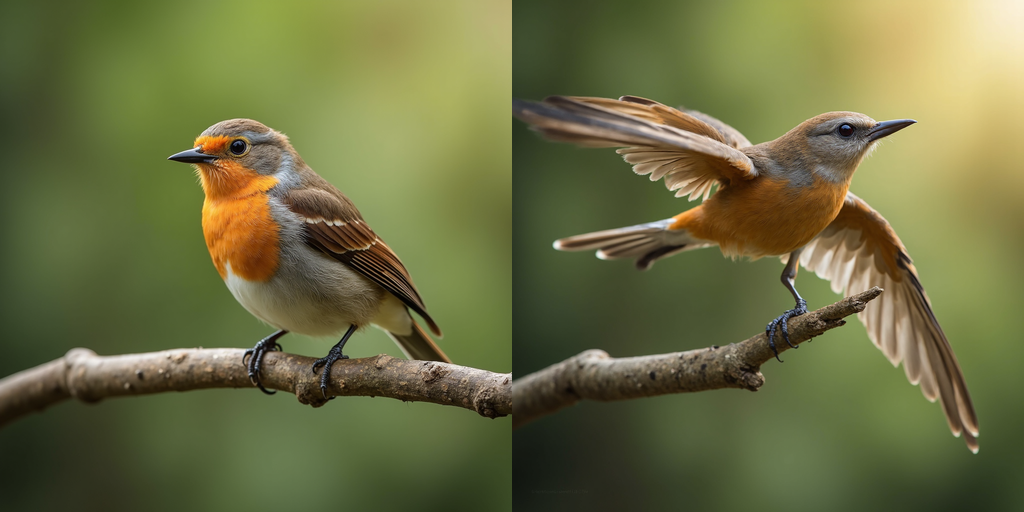

In [5]:
register_non_rigid_attention_control(pipe, **processor_args)
image_masa_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
).images
display(resize_and_concat_images(image_masa_list))
